In [1]:
import pyspark
from pyspark.sql import SparkSession
import synapse.ml

In [2]:
# Create a SparkSession
# spark = SparkSession.builder.appName("TestApp").getOrCreate()
spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.9") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .getOrCreate()

# Check Spark Session Information
spark

25/03/13 13:27:39 WARN Utils: Your hostname, Boths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.41 instead (on interface en0)
25/03/13 13:27:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /Users/both/.ivy2/cache
The jars for the packages stored in: /Users/both/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f8743086-c5f4-4993-a5c1-21de05ecdf74;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.9 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.9 in central


:: loading settings :: url = jar:file:/Users/both/Documents/DS_Projects_Local/telco_churn_project/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.2 in central
	found com.linkedin.isolation-forest#isolation-forest_3.4.2_2.12;3.0.4 in central
	found com.chuusai#shapeless_2.12;2.3.10

In [3]:
df = spark.read.csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [4]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



### **Data Quality Check**

In [5]:
from pyspark.sql.functions import col, sum

In [6]:
def check_missing_values(df):
    missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    return missing_values

# Use the function to check for missing values in the DataFrame
missing_values = check_missing_values(df)
missing_values.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [7]:
# Count total rows and distinct rows
total_rows = df.count()
distinct_rows = df.distinct().count()

print(f"Total Rows: {total_rows}, Distinct Rows: {distinct_rows}")
print(f"Duplicate Rows: {total_rows - distinct_rows}")

Total Rows: 7043, Distinct Rows: 7043
Duplicate Rows: 0


### **Exploratory data analysis**

In [8]:
from pyspark.sql import functions as F
from operator import add
from functools import reduce
from pyspark.sql.functions import sum, count, col, when, size, array, expr
from pyspark.ml.feature import StringIndexer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Suppress warndings
import warnings

warnings.filterwarnings('ignore')

In [9]:
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [10]:
# Calculate churn rate
churn_rate  = df.groupBy().agg((F.sum(when(col("Churn") == "Yes", 1).otherwise(0)) *100/ count("*")).alias("Churn Rate"))
churn_rate.show()

+------------------+
|        Churn Rate|
+------------------+
|26.536987079369588|
+------------------+



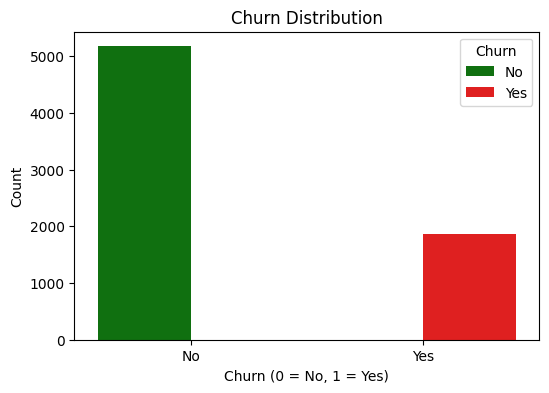

In [11]:
# Convert Churn column to Pandas
churn_data = df.select("Churn").toPandas()

# # Convert Yes to 1 and No to 0
# churn_data["Churn"] = churn_data["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# Set color palette for 0 (green) and 1 (red)
plt.figure(figsize=(6,4))
sns.countplot(data=churn_data, x="Churn", hue ="Churn", palette={"No": 'green', "Yes": 'red'})
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

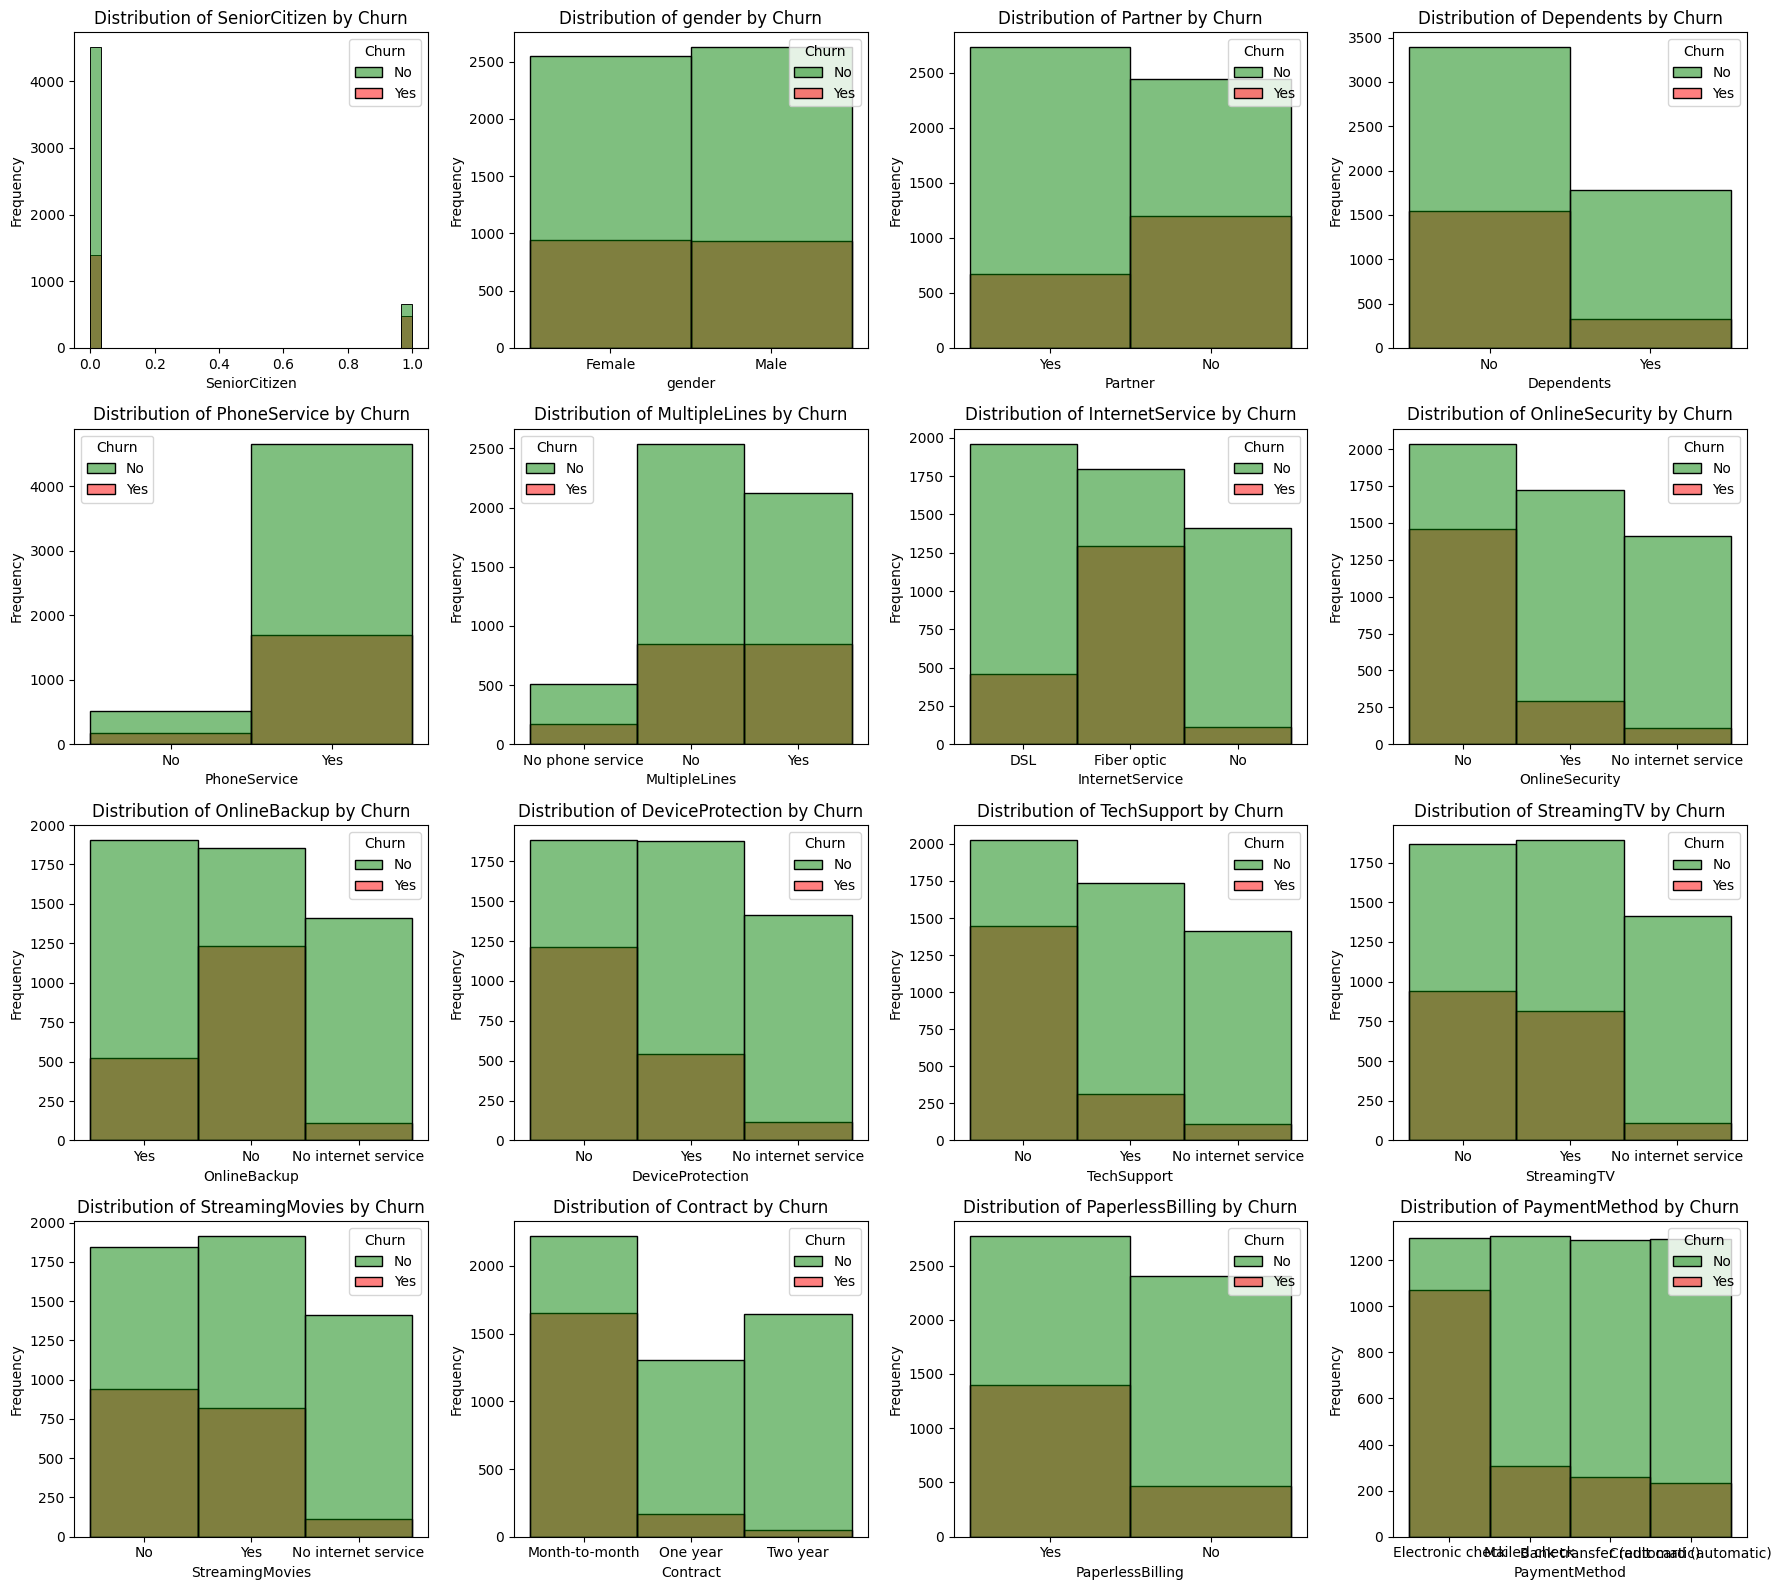

In [12]:
cat_name = ['SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

# Calculate the number of rows and columns for the subplots grid
n_cols = 4
n_rows = (len(cat_name) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

for i, col_name in enumerate(cat_name):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    num_data = df.select(col_name, "Churn").toPandas()

    sns.histplot(data=num_data, x=col_name, hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'}, ax=ax)
    ax.set_title(f"Distribution of {col_name} by Churn")
    ax.set_xlabel(col_name)
    ax.set_ylabel("Frequency")

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

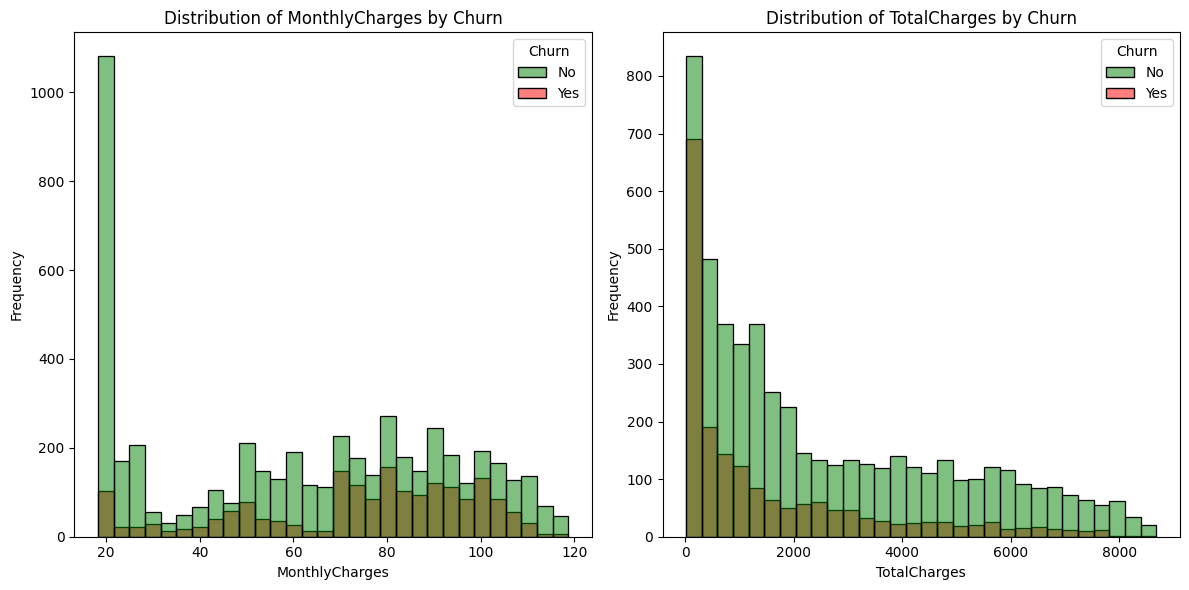

In [13]:
# Convert TotalCharges to float
df = df.withColumn("TotalCharges", df["TotalCharges"].cast("float"))

# Convert to Pandas DataFrame
num_data = df.select("MonthlyCharges", "TotalCharges", "Churn").toPandas()

# Plot MonthlyCharges
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=num_data, x="MonthlyCharges", hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'})
plt.title("Distribution of MonthlyCharges by Churn")
plt.xlabel("MonthlyCharges")
plt.ylabel("Frequency")

# Plot TotalCharges
plt.subplot(1, 2, 2)
sns.histplot(data=num_data, x="TotalCharges", hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'})
plt.title("Distribution of TotalCharges by Churn")
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
# Convert categorical columns to numerical values
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
               'PaperlessBilling', 'PaymentMethod', 'Churn']

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index") for col_name in cat_columns]


df_encoded = df
for indexer in indexers:
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)

In [15]:
# Drop original categorical columns and keep the new indexed ones
df_eda = df_encoded.drop(*cat_columns)
df_eda = df_eda.drop("customerID")
df_eda.show(5)

+-------------+------+--------------+------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+
|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|InternetService_index|OnlineSecurity_index|OnlineBackup_index|DeviceProtection_index|TechSupport_index|StreamingTV_index|StreamingMovies_index|Contract_index|PaperlessBilling_index|PaymentMethod_index|Churn_index|
+-------------+------+--------------+------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+---------------

In [16]:
df_eda = df_eda.withColumnRenamed("Churn_index", "Churn")

# Convert to Pandas DataFrame
df_eda_pd = df_eda.toPandas()

# Compute correlation matrix
correlation_matrix = df_eda_pd.corr()

# Display correlation with Churn
print(correlation_matrix["Churn"].sort_values(ascending=False))

Churn                     1.000000
MonthlyCharges            0.193356
SeniorCitizen             0.150889
MultipleLines_index       0.019423
gender_index              0.008612
PhoneService_index       -0.011942
Partner_index            -0.150448
Dependents_index         -0.164221
PaperlessBilling_index   -0.191825
TotalCharges             -0.199484
StreamingTV_index        -0.205742
StreamingMovies_index    -0.207256
PaymentMethod_index      -0.262818
DeviceProtection_index   -0.281465
OnlineBackup_index       -0.291449
InternetService_index    -0.316846
TechSupport_index        -0.329852
OnlineSecurity_index     -0.332819
Contract_index           -0.341504
tenure                   -0.352229
Name: Churn, dtype: float64


In [17]:
corr_matrix  = correlation_matrix["Churn"].sort_values(ascending=False)
print('Most Positive Correlations:\n', corr_matrix.head(3))
print('\nMost Negative Correlations:\n', corr_matrix.tail(3))

Most Positive Correlations:
 Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn, dtype: float64

Most Negative Correlations:
 OnlineSecurity_index   -0.332819
Contract_index         -0.341504
tenure                 -0.352229
Name: Churn, dtype: float64


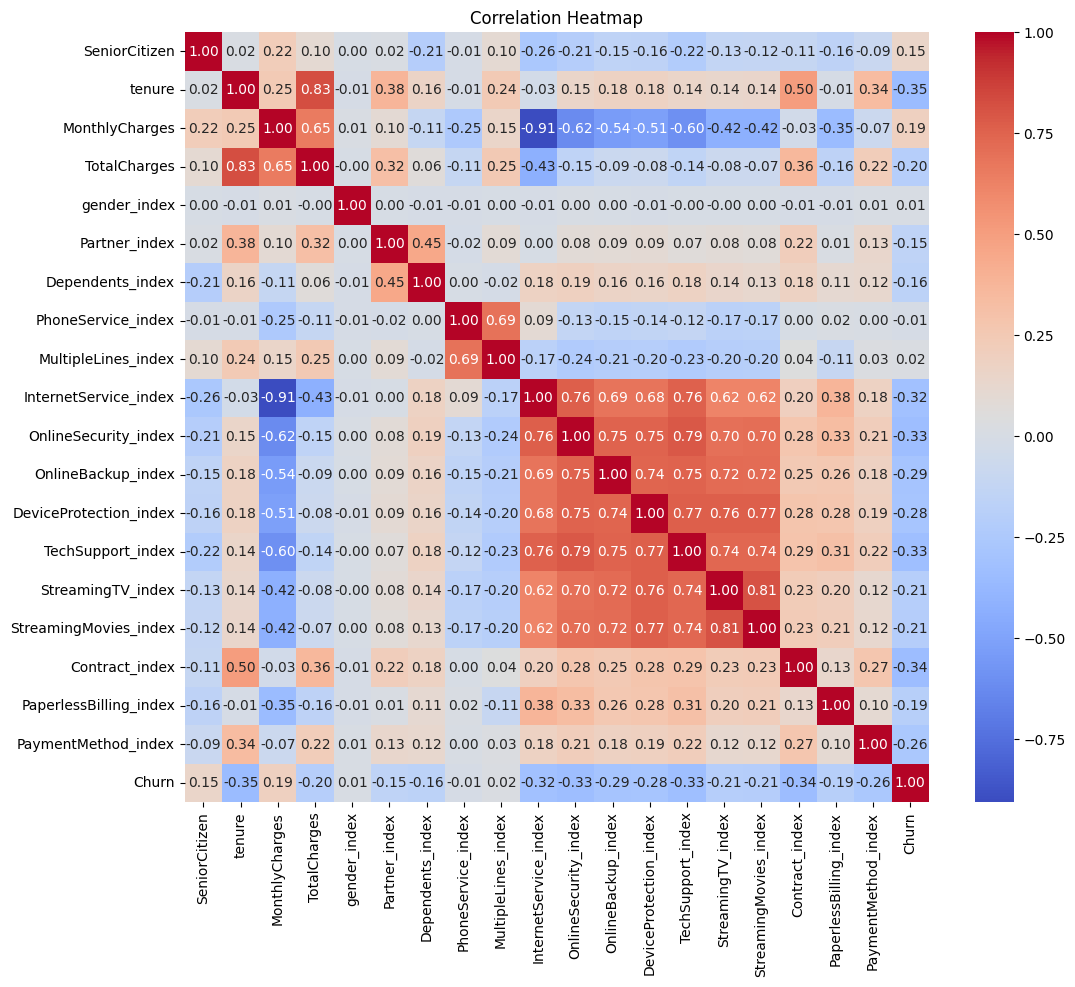

In [18]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

### **Model Building**

In [19]:
from pyspark.sql.functions import col, when, count, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_recall_curve,auc
import math

In [35]:
# Load data
df_final = df # Use the Dataframe prior encoder for EDA
target_col = "Churn"  # Replace with your actual target column

In [ ]:
# Convert Churn column from string to integer
df_final = df_final.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



In [44]:
# Define train-test ratio
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split each class separately
minority_class = df_final.filter(F.col(target_col) == 1)
majority_class = df_final.filter(F.col(target_col) == 0)

train_minority, test_minority = minority_class.randomSplit([train_ratio, test_ratio], seed=42)
train_majority, test_majority = majority_class.randomSplit([train_ratio, test_ratio], seed=42)

# Combine training and testing sets
train_data = train_minority.union(train_majority)
test_data = test_minority.union(test_majority)

# Verify class balance in the new splits
train_data.groupBy(target_col).count().orderBy("count", ascending=False).show()
test_data.groupBy(target_col).count().orderBy("count", ascending=False).show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0| 4173|
|    1| 1541|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    0| 1001|
|    1|  328|
+-----+-----+



In [ ]:
# spark.stop()